<a href="https://colab.research.google.com/github/Hitansh159/match-filter/blob/main/clonvo_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp drive/MyDrive/dataset.zip ./

In [2]:
!unzip *.zip 

Archive:  dataset.zip
   creating: content/dataset/
   creating: content/dataset/.ipynb_checkpoints/
  inflating: content/dataset/target.csv  
   creating: content/dataset/narendra modi/
  inflating: content/dataset/narendra modi/173.wav  
  inflating: content/dataset/narendra modi/777.wav  
  inflating: content/dataset/narendra modi/416.wav  
  inflating: content/dataset/narendra modi/555.wav  
  inflating: content/dataset/narendra modi/466.wav  
  inflating: content/dataset/narendra modi/90.wav  
  inflating: content/dataset/narendra modi/381.wav  
  inflating: content/dataset/narendra modi/549.wav  
  inflating: content/dataset/narendra modi/253.wav  
  inflating: content/dataset/narendra modi/356.wav  
  inflating: content/dataset/narendra modi/128.wav  
  inflating: content/dataset/narendra modi/397.wav  
  inflating: content/dataset/narendra modi/430.wav  
  inflating: content/dataset/narendra modi/168.wav  
  inflating: content/dataset/narendra modi/609.wav  
  inflating: conten

In [3]:
!mv ./content/* ./

In [4]:
!rm -r ./content

In [5]:
import tensorflow as tf
import numpy as np
import librosa
import os 
import pandas as pd
import numpy as np
import soundfile as sf
import IPython
import matplotlib.pyplot as plt


In [6]:
dataset_frame = pd.read_csv('./dataset/target.csv')

In [7]:
dataset_frame.rename(columns={'Unnamed: 0': 'filename'}, inplace=True)

In [8]:
dataset_frame['filename'] = dataset_frame['filename'].apply(lambda x: f'./dataset/narendra modi/{x}.wav')

In [9]:
def convert_string_to_array(s):
  y = list(map(lambda x : float(x), s[1:-1].split(',') ))
  kernel = 255
  res = []
  for i in range(0, len(y), kernel):
    if sum(y[i: i+kernel]):
      res.append(1)
    else:
      res.append(0)
  return res

In [10]:
dataset_frame['y'] = dataset_frame['y'].apply(convert_string_to_array)

In [12]:
dataset_frame

,filename,y
0,./dataset/narendra modi/0.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,./dataset/narendra modi/1.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,./dataset/narendra modi/2.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,./dataset/narendra modi/3.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,./dataset/narendra modi/4.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
811,./dataset/narendra modi/811.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
812,./dataset/narendra modi/812.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
813,./dataset/narendra modi/813.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
814,./dataset/narendra modi/814.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
def dataloader(total):
  item = 0
  while item < total:
    audio, sr = librosa.load(dataset_frame['filename'][item])
    if len(audio) < 220500:
      audio = np.pad(audio, (0,220500-len(audio)), 'constant', constant_values=0)
    yield audio.reshape((220500, 1)), dataset_frame['y'][item]
    item += 1

In [28]:
ds_genrator = tf.data.Dataset.from_generator(dataloader, args=[816], output_types=(tf.float64, tf.float64),
                                             output_shapes=(
                                                            tf.TensorShape((220500, 1)),
                                                            tf.TensorShape((865))))

In [50]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Conv1D(120, 15, 4, padding='valid'))
model0.add(tf.keras.layers.Conv1D(252, 36, 7, padding='valid'))
model0.add(tf.keras.layers.Conv1D(1025, 90, 9, padding='valid'))
model0.add(tf.keras.layers.LSTM(1025, activation='tanh', return_sequences=True))
model0.add(tf.keras.layers.Dense(1025, activation='relu'))
model0.add(tf.keras.layers.LSTM(1025, activation='tanh', return_sequences=True))
model0.add(tf.keras.layers.Dense(1025, activation='relu'))
model0.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='softmax')))

In [51]:
model0.build([None, 220500, 1])
model0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 55122, 120)        1920      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 7870, 252)         1088892   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 865, 1025)         23248025  
_________________________________________________________________
lstm_4 (LSTM)                (None, 865, 1025)         8409100   
_________________________________________________________________
dense_6 (Dense)              (None, 865, 1025)         1051650   
_________________________________________________________________
lstm_5 (LSTM)                (None, 865, 1025)         8409100   
_________________________________________________________________
dense_7 (Dense)              (None, 865, 1025)        

In [65]:
# model0.compile(optimizer= 'adam', loss='mse', metrics=['mse'])
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'AUC', 'Recall'])

In [66]:
history = model0.fit(x= ds_genrator.batch(64), batch_size=64, epochs=5, verbose=1)

Epoch 1/5
13/13 [==============================] - 166s 12s/step - loss: 2044.7891 - accuracy: 0.3496 - precision: 0.3496 - auc: 0.5000 - recall: 1.0000
Epoch 2/5
13/13 [==============================] - 144s 11s/step - loss: 2044.7891 - accuracy: 0.3496 - precision: 0.3496 - auc: 0.5000 - recall: 1.0000
Epoch 3/5
 7/13 [===============>..............] - ETA: 1:07 - loss: 2006.5380 - accuracy: 0.3430 - precision: 0.3430 - auc: 0.5000 - recall: 1.0000

KeyboardInterrupt: ignored

In [67]:
for i in ds_genrator.take(1):
  x_= i[0]
  y = i[1]

In [68]:
y_ = model0.predict(ds_genrator.batch(1).take(1), batch_size=1)

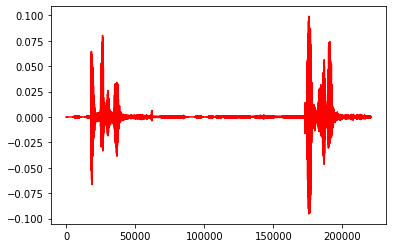

In [69]:
plt.plot(x_, color='red')

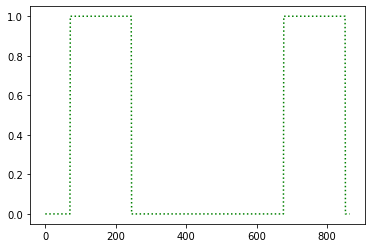

In [70]:
plt.plot(y, color='green', linestyle='dotted')

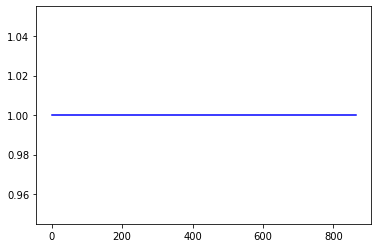

In [71]:
plt.plot(y_[0], color='blue')

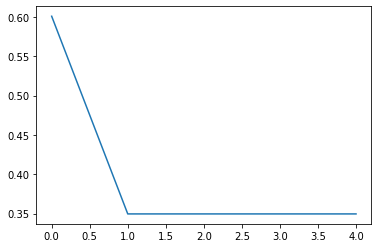

In [72]:
plt.plot(history.history['loss'])

In [78]:
sum(y)

<tf.Tensor: shape=(), dtype=float64, numpy=349.0>

In [80]:
y.shape

TensorShape([865])

In [82]:
865 - 349

516